# Leaky integrate and fire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import brian2 as b

## Neurons

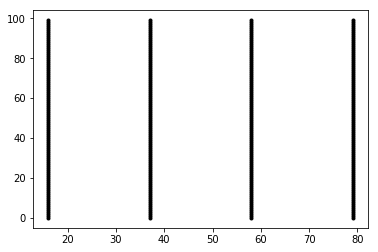

In [5]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (1 - v) / tau_membrane : 1 (unless refractory)
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )

state_monitor = b.StateMonitor( neuron_group, 'v', record = 0 )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 100 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

## Synapses

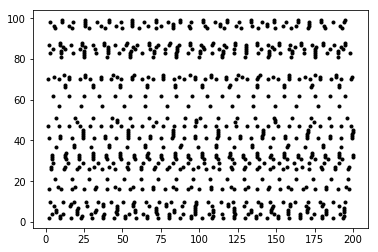

In [18]:
b.start_scope()

N = 100
tau_membrane = 10 * b.ms
equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
'''

neuron_group = b.NeuronGroup( N, equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) )

synapses = b.Synapses( neuron_group, neuron_group,
                       on_pre = 'v_post += 0.3' )

for i in range( N - 1 ):
    synapses.connect( i = i, j = i + 1 )

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group )

b.run( 200 * b.ms )

plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

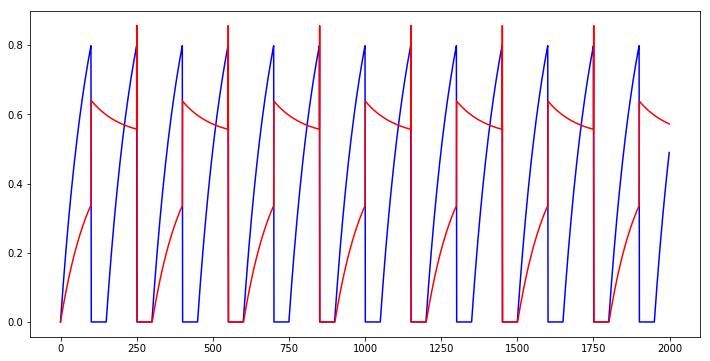

In [23]:
plt.figure( figsize = (12, 6) )
plt.plot( state_monitor.v[81, :], 'b-' )
plt.plot( state_monitor.v[82, :], 'r-' )

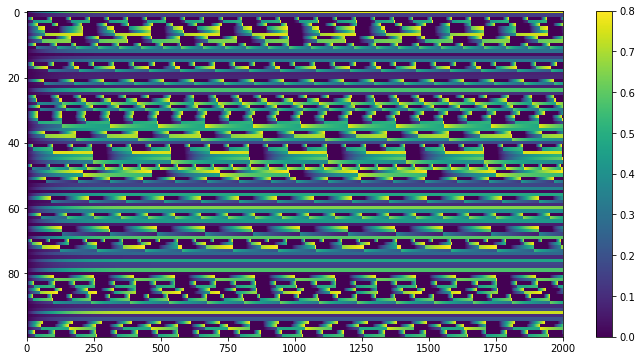

In [20]:
plt.figure( figsize = (12, 6) )
plt.imshow( state_monitor.v, aspect = 'auto' )
plt.clim( 0., 0.8 )
plt.colorbar()

## STDP

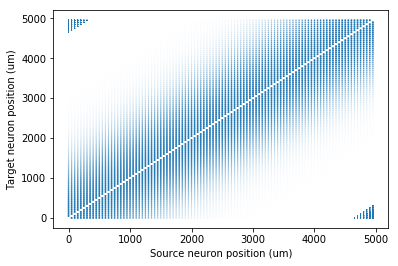

In [46]:
b.start_scope()

N = 100

tau_membrane = 10 * b.ms
tau_pre_synapse = 20 * b.ms
tau_post_synapse = 20 * b.ms

w_max = 0.05
Apre = -0.01
Apost = -Apre * ( tau_pre_synapse / tau_post_synapse ) * 0.95 # 1.05

neuron_spacing = 50 * b.umeter
total_width = (N / 8.) * neuron_spacing

neuron_equations = '''
dv/dt = (I - v) / tau_membrane : 1 (unless refractory)
I : 1
x : meter
'''

neuron_group = b.NeuronGroup( N, neuron_equations,
                              threshold = 'v > 0.8',
                              reset = 'v = 0',
                              refractory = 5 * b.ms,
                              method = 'euler' )
neuron_group.I = np.random.exponential( size = (N,) ) * 1.
neuron_group.x = 'i * neuron_spacing'

synapse_equations = '''
w : 1
dapre/dt = -apre / tau_pre_synapse : 1 (event-driven)
dapost/dt = -apost / tau_post_synapse : 1 (event-driven)
'''
synapse_on_pre = '''
v_post += w
apre += Apre
w = clip( w + apost, 0, w_max)
'''
synapse_on_post = '''
apost += Apost
w = clip( w + apre, 0, w_max)
'''

synapses = b.Synapses( neuron_group, neuron_group, synapse_equations,
                       on_pre = synapse_on_pre,
                       on_post = synapse_on_post )

synapses.connect( condition = 'i != j' )
synapses.w = 'w_max * exp( -( x_pre - x_post ) ** 2 / ( 2 * total_width ** 2 ) )'

plt.scatter( synapses.x_pre/b.um, synapses.x_post/b.um, synapses.w*20)
plt.xlabel('Source neuron position (um)')
plt.ylabel('Target neuron position (um)');

state_monitor = b.StateMonitor( neuron_group, 'v', record = True )
spike_monitor = b.SpikeMonitor( neuron_group )

synapse_monitor = b.StateMonitor( synapses, ['w', 'i', 'j'], record = True )

b.run( 2000 * b.ms )

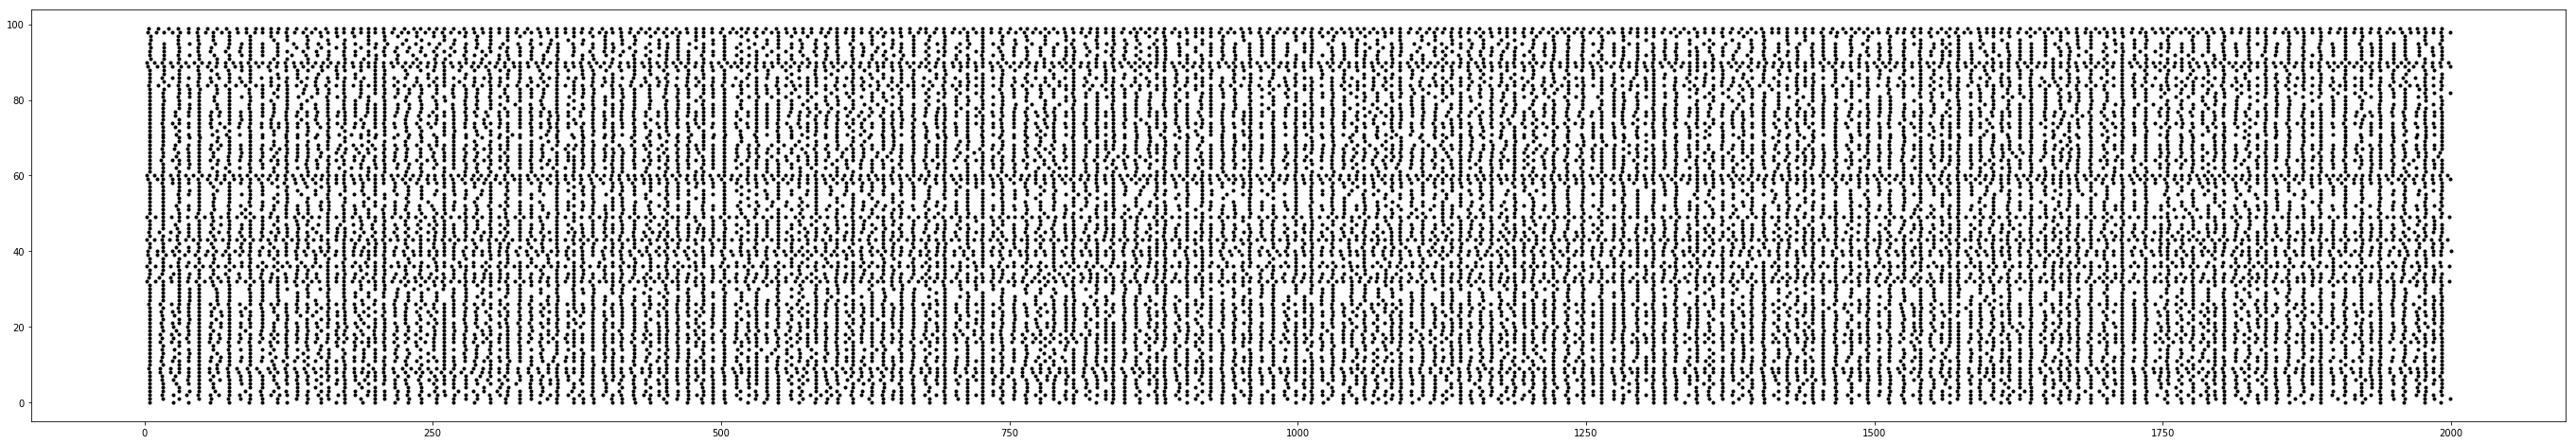

In [47]:
plt.figure( figsize = (48, 8) )
plt.plot( spike_monitor.t / b.ms, spike_monitor.i, 'k.' )

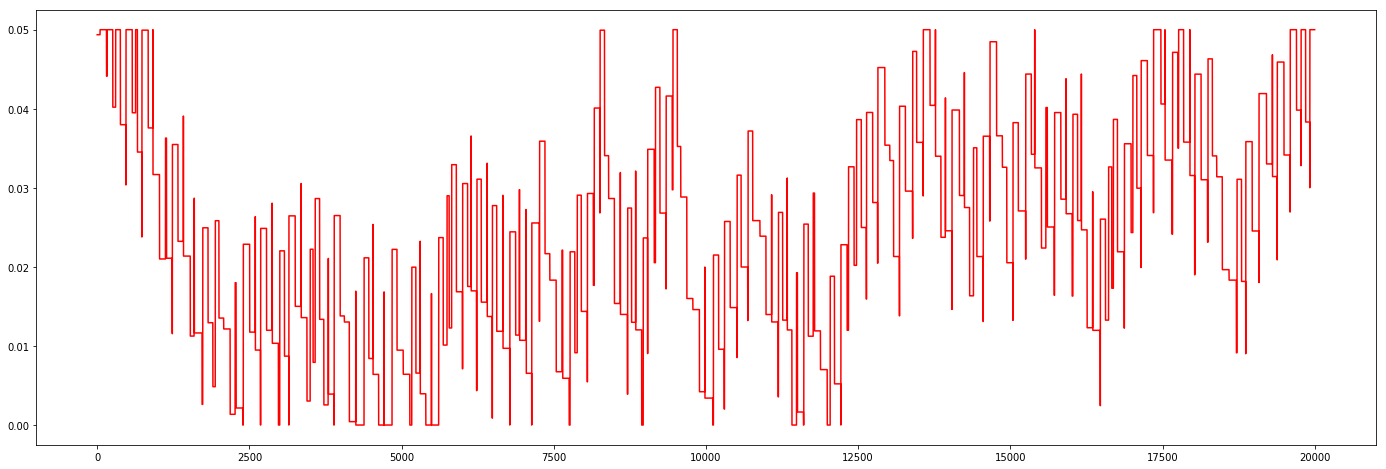

In [48]:
synapse_i =  synapse_monitor.i[:, 0]
synapse_j = synapse_monitor.j[:, 0]

plt.figure( figsize = (24, 8) )
plt.plot( synapse_monitor.w[1001, :], 'r-' )

In [49]:
import gc
gc.collect()

2206

In [50]:
plt.figure( figsize = (24, 12) )
plt.imshow( synapse_monitor.w, aspect = 'auto' )
plt.clim( 0, 0.05 )

MemoryError: Unable to allocate array with shape (9900, 20000) and data type float64

<Figure size 1728x864 with 0 Axes>

In [ ]:
import gc
gc.collect()